해당 파일은 최종 제출 목록 중 Ensemble_test에 대한 output을 출력하는 파일입니다.

Ensemble_test는 제출 중 성능이 뛰어난 편은 아니었지만, 팀 내에서 수행한 EDA 결과를 바탕으로 Feature Engineering을 진행하고 모델링한 예측으로서의 의미를 가진다고 판단하여 최종 제출로 선정했습니다.

## Library Import

In [5]:
import os
from typing import Any, List, Dict, Tuple
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import lightgbm as lgb
import optuna
import seaborn as sns
from sklearn.ensemble import VotingRegressor
from data_preprocessing import *
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

c:\Users\Home\anaconda3\envs\AI_tech\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# Data Load

In [7]:
# 파일 호출
data_path: str = "/data/ephemeral/home/BTC/data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

PermissionError: [Errno 13] Permission denied: 'C:/Users/Home/Desktop/data/data\\test.csv'

In [ ]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


In [ ]:
# EDA를 위한 2023년 훈련 데이터프레임 생성
eda_df = df.loc[df["_type"] == "train"]
eda_df.head()

# EDA
## Feature Selection
* 모든 feature와 target 사이의 상관관계를 보기 위해 각 csv 파일에서의 column을 모두 추출한다.
* 단, {exchanges|symbol}이 포함된 csv 파일에서는 all_exchange 또는 all_symbol만 가져온다.
* 위 케이스 중 전체 거래소/코인으로 선택된 endpoint 리스트는 다음 4가지이다.

    * **market data** 
        
        funding rates, liquidations, taker buy sell stats, open interest

In [32]:
# 열 선택 기준
# {exchanges|symbol}이 포함된 csv 파일에서는 all_exchange 또는 all_symbol만 가져온다.
# 그렇게 선택된 endpoint 리스트는 다음 4가지이다.
# market data에서 funding rates, liquidations, taker buy sell stats, open interest
eda_cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",

    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close": "close",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume": "volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "taker_buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "taker_sell_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "taker_buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "taker_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "taker_buy_sell_ratio",
    "hourly_network-data_addresses-count_addresses_count_active": "addresses_count_active",
    "hourly_network-data_addresses-count_addresses_count_sender": "addresses_count_sender",
    "hourly_network-data_addresses-count_addresses_count_receiver": "addresses_count_receiver",
    "hourly_network-data_block-bytes_block_bytes": "block_bytes",
    "hourly_network-data_block-count_block_count": "block_count",
    "hourly_network-data_block-interval_block_interval": "block_interval",
    "hourly_network-data_blockreward_blockreward": "blockreward",
    "hourly_network-data_blockreward_blockreward_usd": "blockreward_usd",
    "hourly_network-data_difficulty_difficulty": "difficulty",
    "hourly_network-data_fees_fees_block_mean": "fees_block_mean",
    "hourly_network-data_fees_fees_block_mean_usd": "fees_block_mean_usd",
    "hourly_network-data_fees_fees_total": "fees_total",
    "hourly_network-data_fees_fees_total_usd": "fees_total_usd",
    "hourly_network-data_fees_fees_reward_percent": "fees_reward_percent",
    "hourly_network-data_fees-transaction_fees_transaction_mean": "fees_transaction_mean",
    "hourly_network-data_fees-transaction_fees_transaction_mean_usd": "fees_transaction_mean_usd",
    "hourly_network-data_fees-transaction_fees_transaction_median": "fees_transaction_median",
    "hourly_network-data_fees-transaction_fees_transaction_median_usd": "fees_transaction_median_usd",
    "hourly_network-data_hashrate_hashrate": "hashrate",
    "hourly_network-data_supply_supply_total": "supply_total",
    "hourly_network-data_supply_supply_new": "supply_new",
    "hourly_network-data_tokens-transferred_tokens_transferred_total": "tokens_transferred_total",
    "hourly_network-data_tokens-transferred_tokens_transferred_mean": "tokens_transferred_mean",
    "hourly_network-data_tokens-transferred_tokens_transferred_median": "tokens_transferred_median",
    "hourly_network-data_transactions-count_transactions_count_total": "transactions_count_total",
    "hourly_network-data_transactions-count_transactions_count_mean": "transactions_count_mean",
    "hourly_network-data_utxo-count_utxo_count": "utxo_count",
    "hourly_network-data_velocity_velocity_supply_total": "velocity_supply_total"
}
# 추출 후 단순화를 위해 rename: 기존 csv 파일에서의 column명으로 대체한다.
eda_df = eda_df[eda_cols_dict.keys()].rename(eda_cols_dict, axis=1)

In [ ]:
# 상관관계 그리기 전 데이터 타입, Null값 유무 확인
eda_df.info()

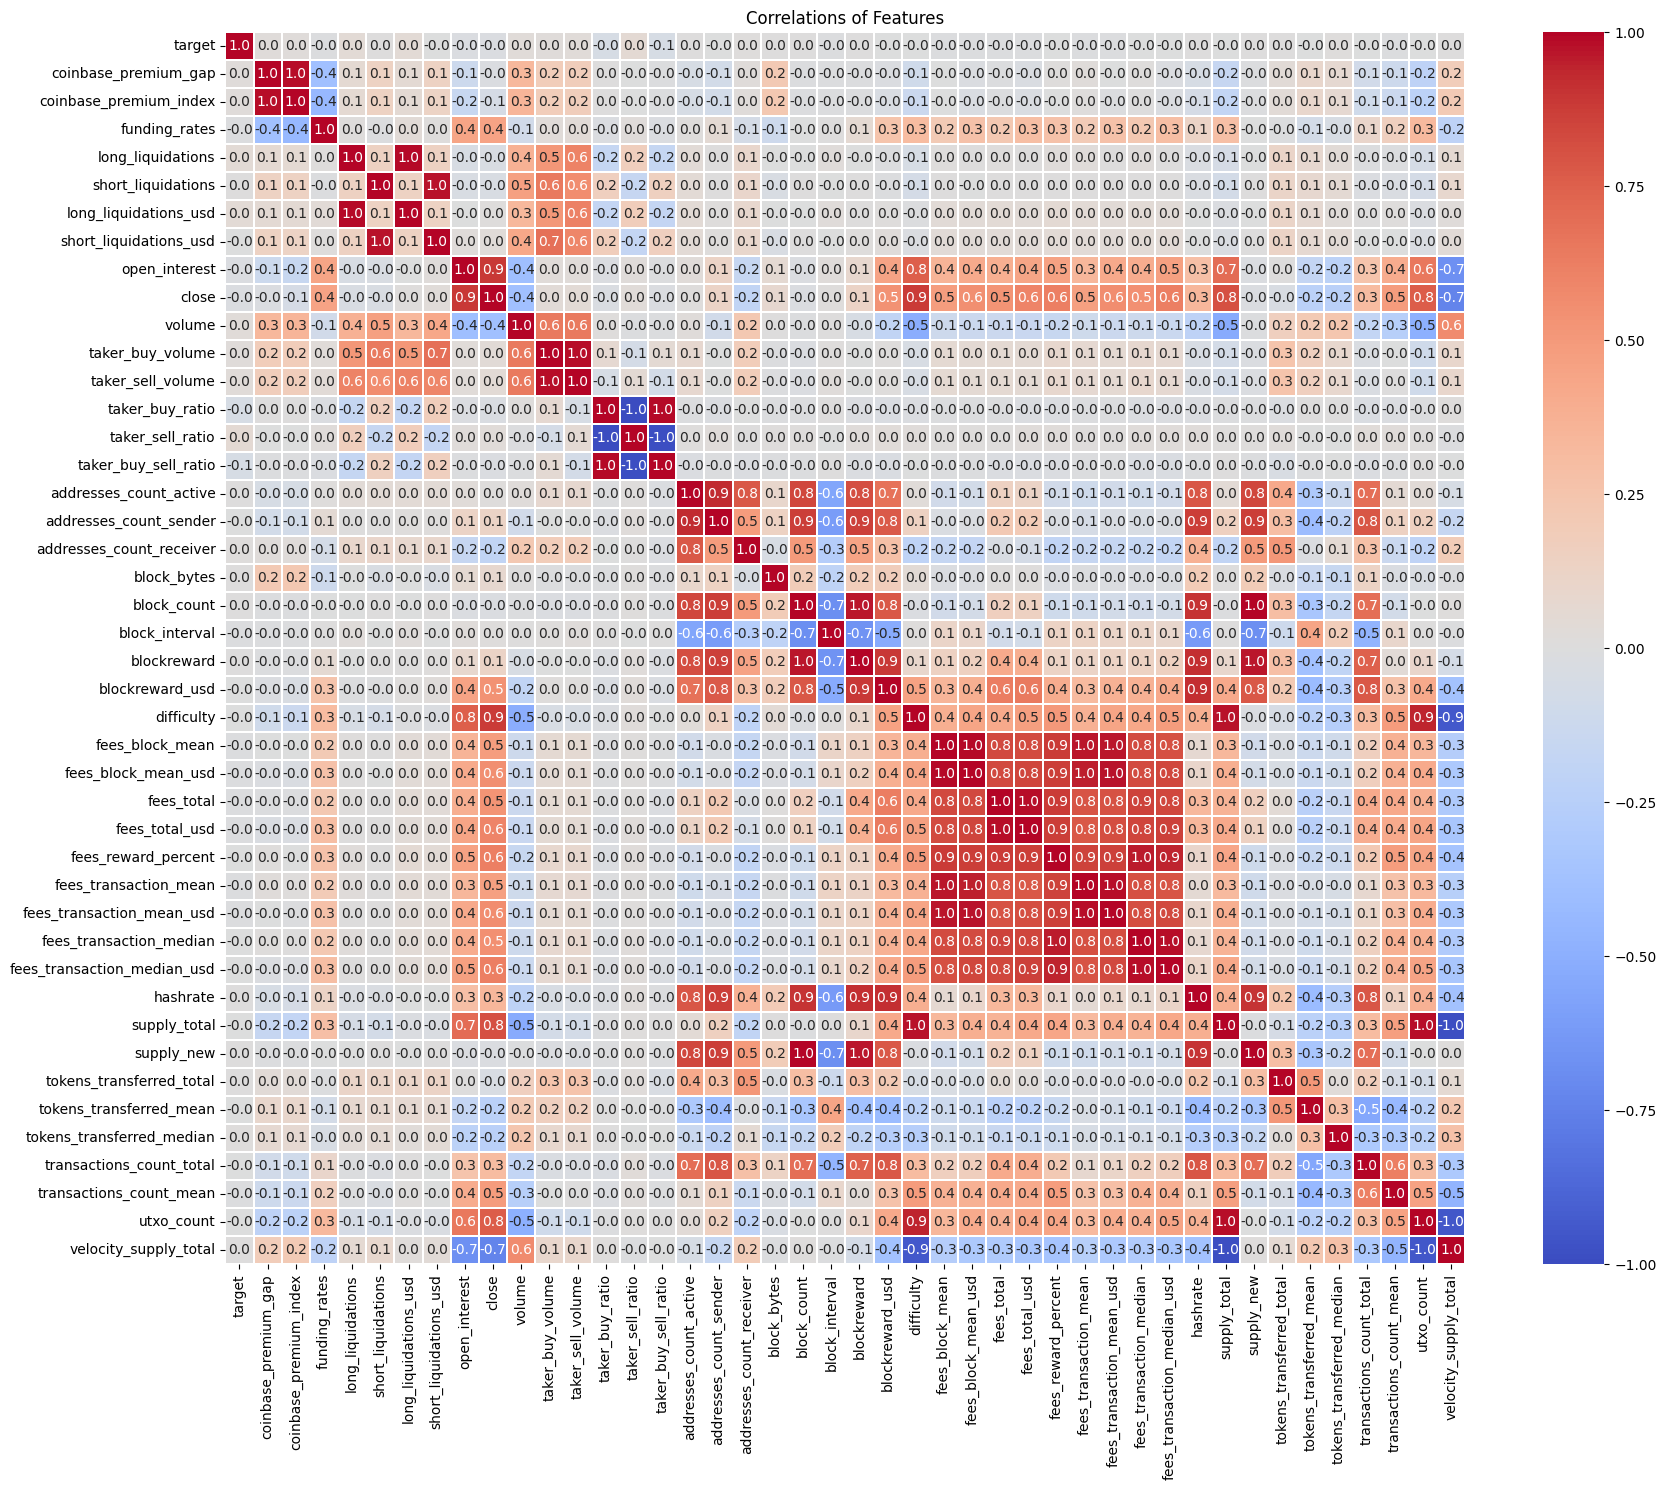

In [34]:
# 변수 간 상관관계 시각화
corr_df = eda_df.drop(columns='ID', inplace=False).corr()

mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = False
plt.figure(figsize=(20, 16))
sns.heatmap(
    corr_df, 
    cmap='coolwarm', 
    annot=True, 
    fmt='.1f', 
    linewidth=0.2, 
    square=True,
    )
plt.title('Correlations of Features')
plt.show()

(array([ 740.,    0.,    0., 3544.,    0.,    0., 3670.,    0.,    0.,
         806.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

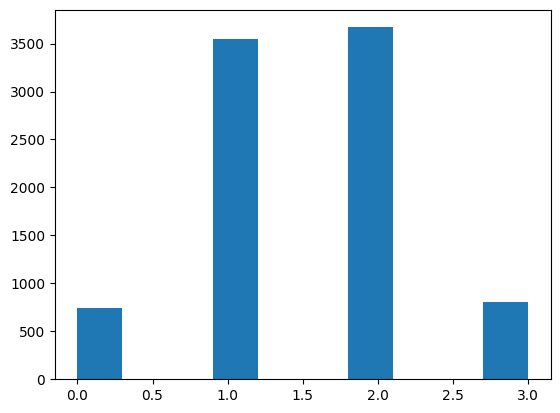

In [35]:
# close 변수를 클래스화해 target과 일치하는지 확인인
close = pd.DataFrame()
close['close'] = eda_df.loc[:, 'close']
close['close_lag1'] = close['close'].shift(1)
close['close_lag1_percent'] = (close['close'] - close['close_lag1']) / close['close_lag1']
close['class'] = close['close']
for i in range(close.shape[0]):
    if close.loc[i, 'close_lag1_percent'] < -0.005:
        close.loc[i, 'class'] = 0
    elif close.loc[i, 'close_lag1_percent'] < 0:
        close.loc[i, 'class'] = 1
    elif close.loc[i, 'close_lag1_percent'] < 0.005:
        close.loc[i, 'class'] = 2
    else:
        close.loc[i, 'class'] = 3

plt.hist(close['class'])

In [36]:
(close['class'].shift(-1) == eda_df['target']).mean()

0.9998858447488584

In [37]:
def double_plot(
    data: pd.DataFrame,
    lefty: str,
    righty: str,
    leftax: matplotlib.axes._axes.Axes,
    rightalpha: float,
    leftlabel: bool=True,
    rightlabel: bool=True
)-> None:
    """twinx를 이용한 비교 차트 생성 함수입니다.

    Args:
        data (pd.DataFrame): 차트를 그릴 데이터프레임
        lefty (str): 왼쪽에 라벨링할 column의 이름
        righty (str): 오른쪽에 라벨링할 column의 이름
        leftax (matplotlib.axes._axes.Axes): 차트를 그릴 축
        rightalpha (float): 오른쪽에 그릴 차트의 alpha 값
        leftlabel (bool): 왼쪽 ylabel을 나타낼지 여부
        rightlabel (bool): 오른쪽 ylabel을 나타낼지 여부
    
    Returns:
        None
    """

    leftax.plot(data[lefty], color='tomato')
    if leftlabel: leftax.set_ylabel(lefty, color='tomato')

    rightax = leftax.twinx()
    rightax.plot(data[righty], color='royalblue', alpha=rightalpha)
    if rightlabel: rightax.set_ylabel(righty, color='royalblue')
    rightax.tick_params(labelcolor='royalblue')

    leftax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    rightax.tick_params(left=False, right=False, labelright=False)


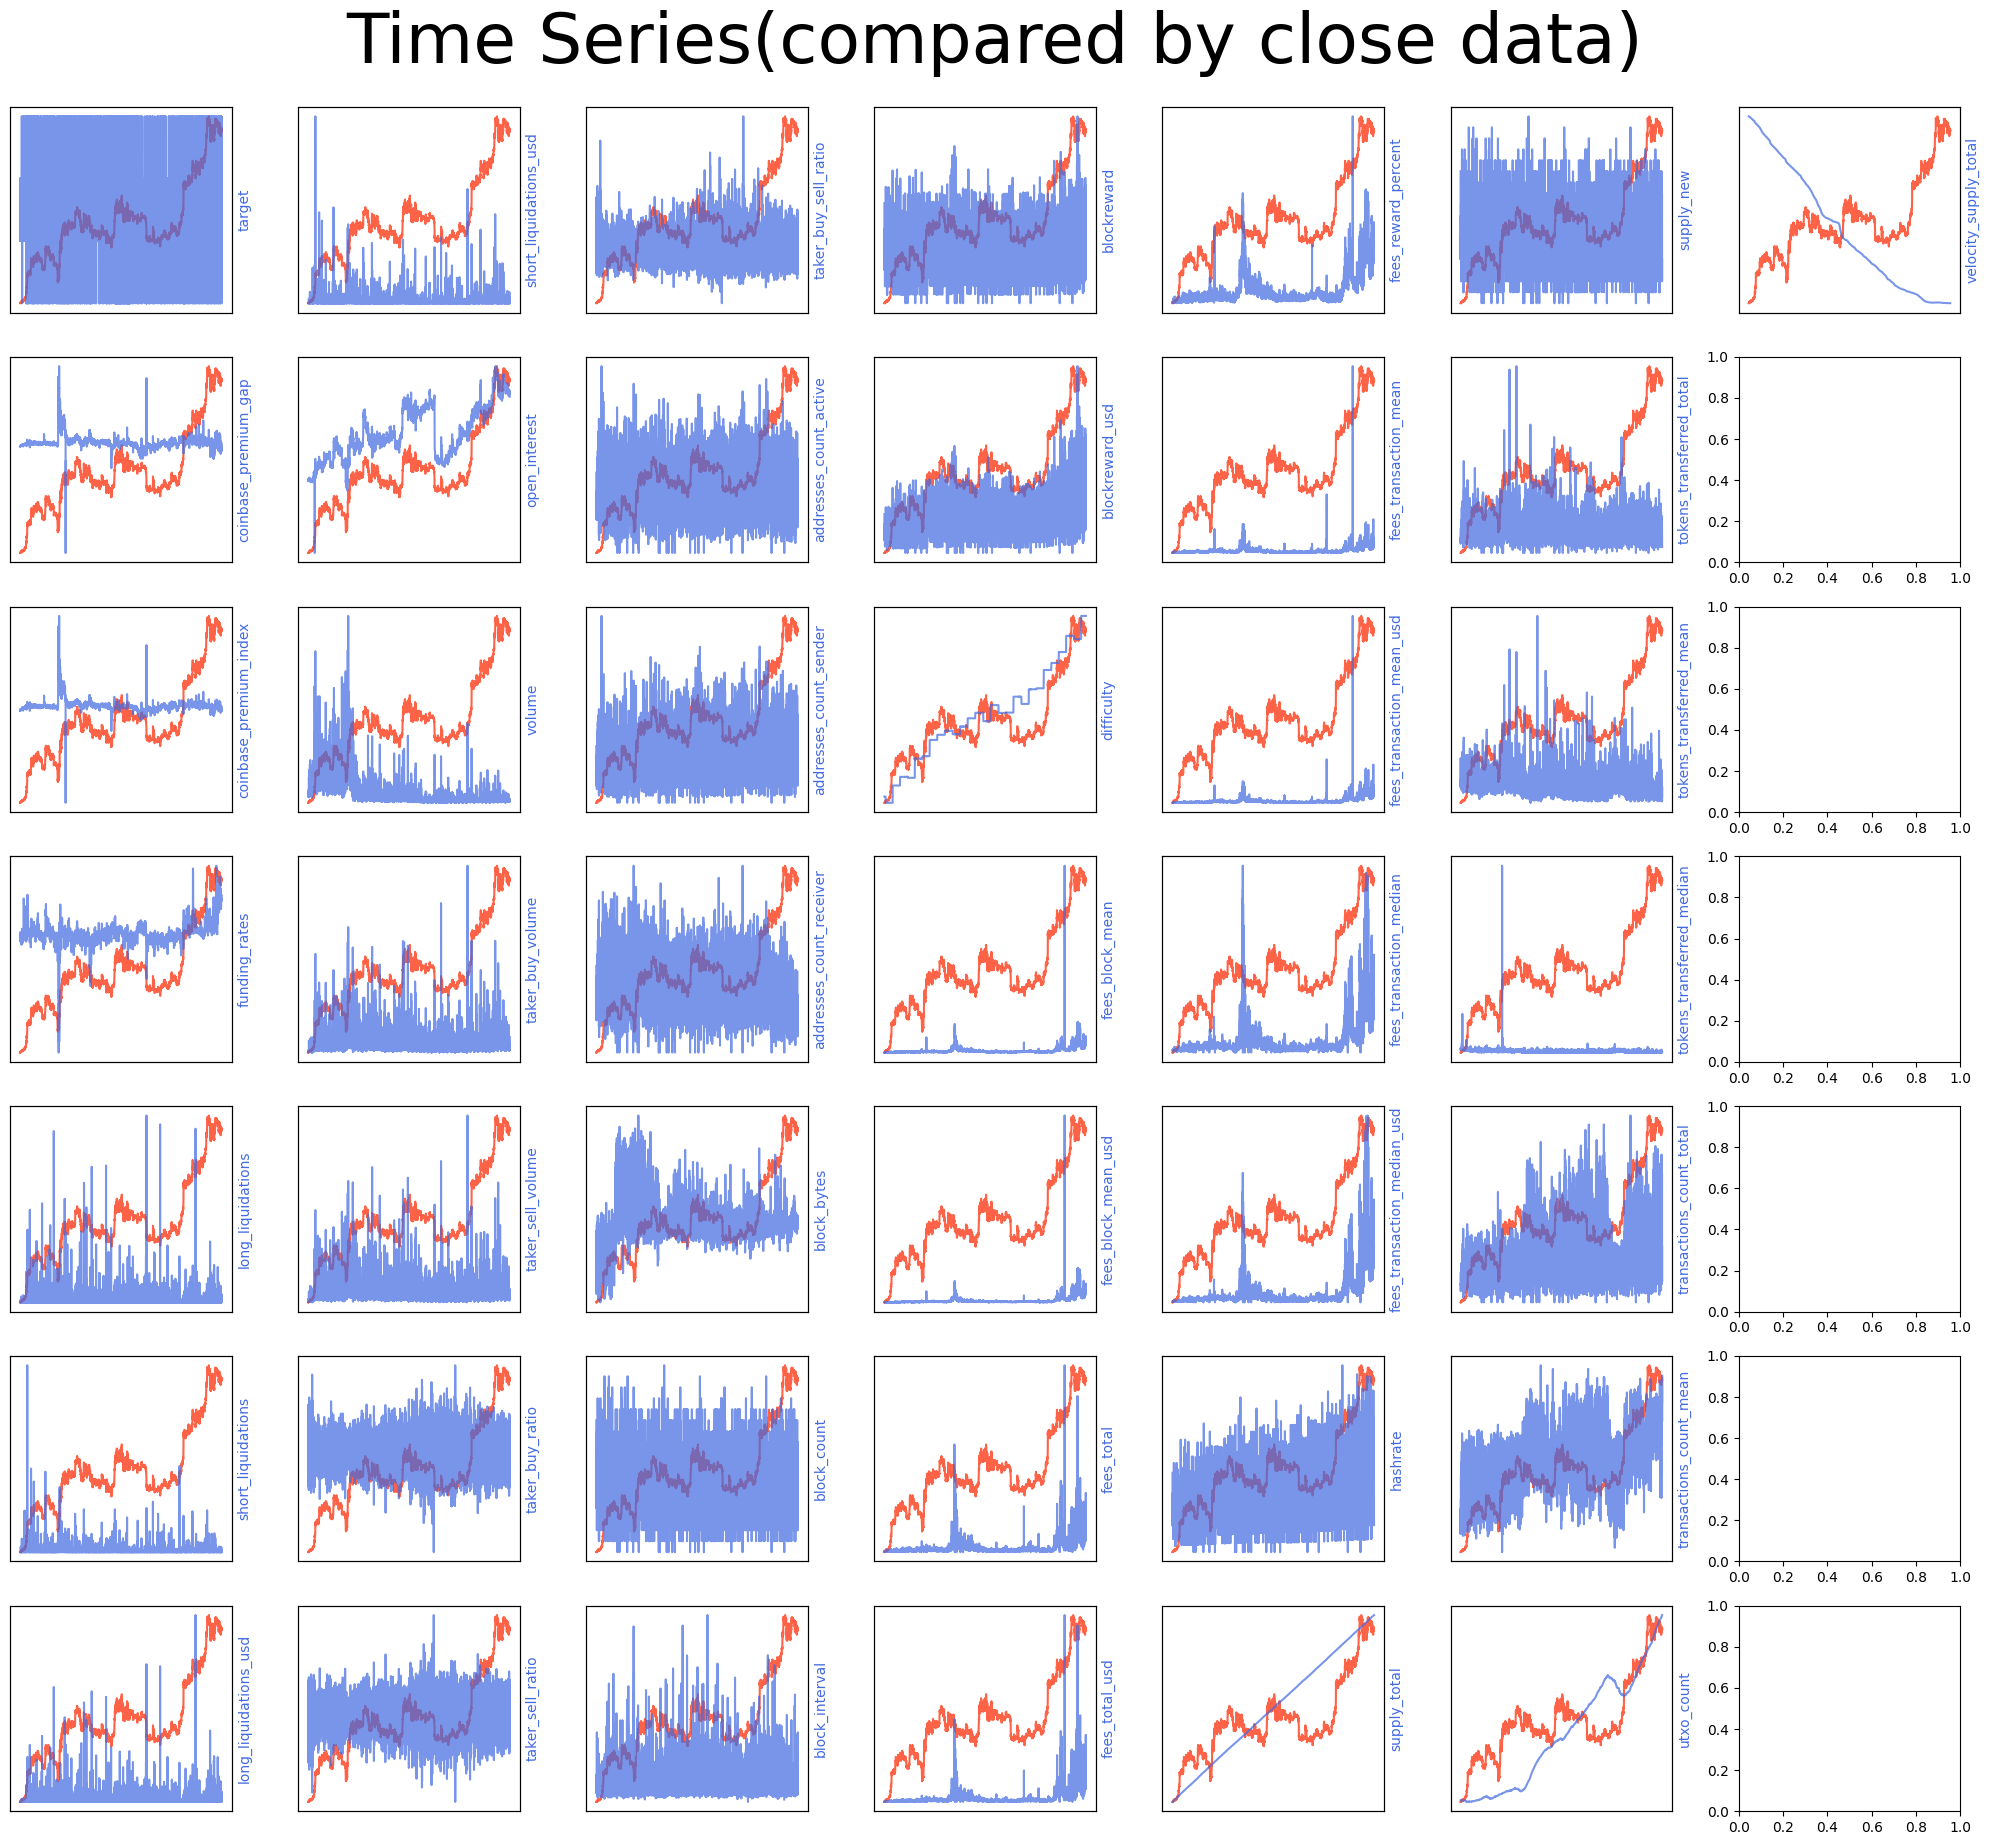

In [38]:
# close에 대한 회귀 수행을 위해 변수별 close 값과의 시게열을 비교해봄
fig, axs = plt.subplots(7, 7, figsize=(20, 20))

for i, feature in enumerate(eda_df.drop(['ID', 'close'], axis=1).columns):
    double_plot(data=eda_df, lefty='close', righty=feature, leftax=axs[i%7, i//7], rightalpha=0.7,
                leftlabel=False)

fig.suptitle('Time Series(compared by close data)', fontsize=50, y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

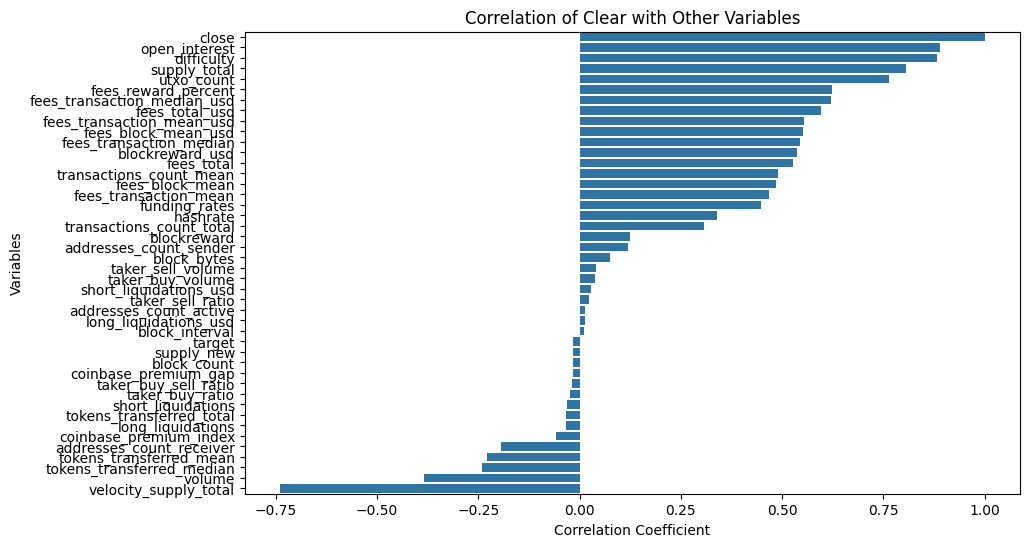

In [39]:
# close와의 상관관계만을 파악
close_correlations = corr_df['close'].sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(y=close_correlations.index, x=close_correlations.values, orient='h')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variables')
plt.title('Correlation of Clear with Other Variables')
plt.show()

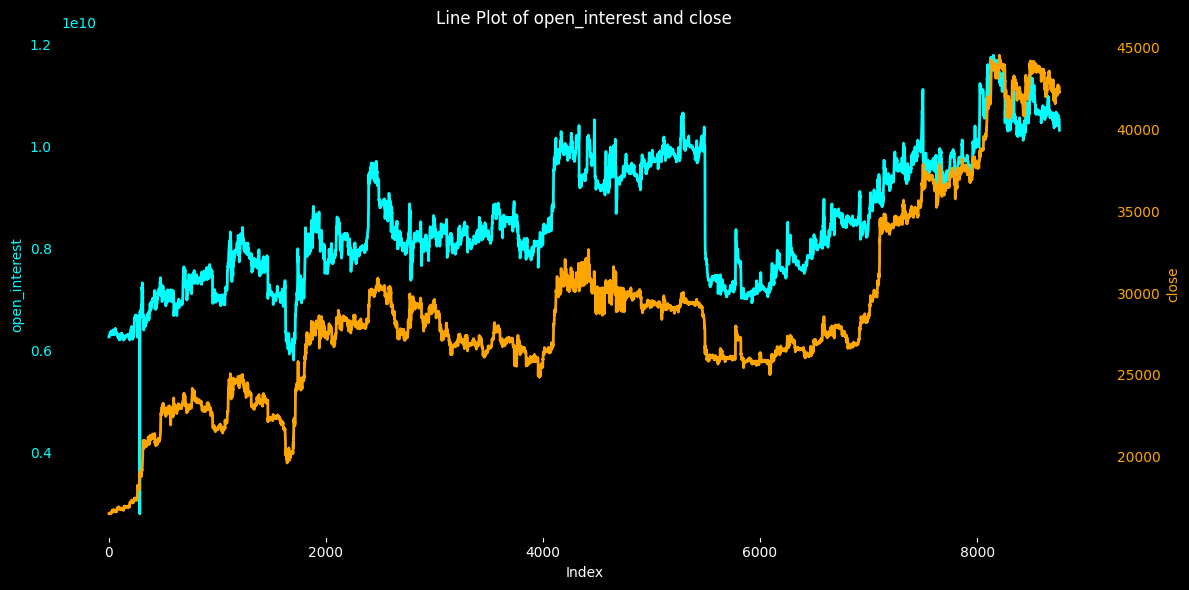

In [40]:
# open_interest & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'open_interest'을 주 Y축에 그리기
ax1.plot(eda_df['open_interest'], label='open_interest', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('open_interest', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of open_interest and close', color='white')
fig.tight_layout()
plt.show()


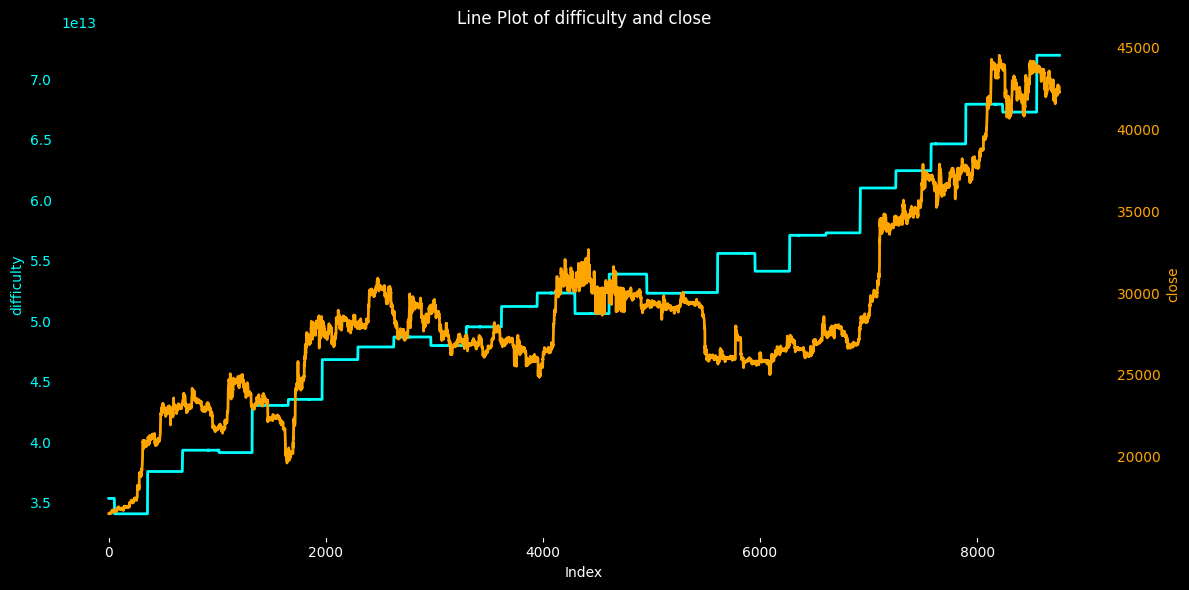

In [41]:
# difficulty & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

ax1.plot(eda_df['difficulty'], label='difficulty', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('difficulty', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Line Plot of difficulty and close', color='white')
fig.tight_layout()
plt.show()


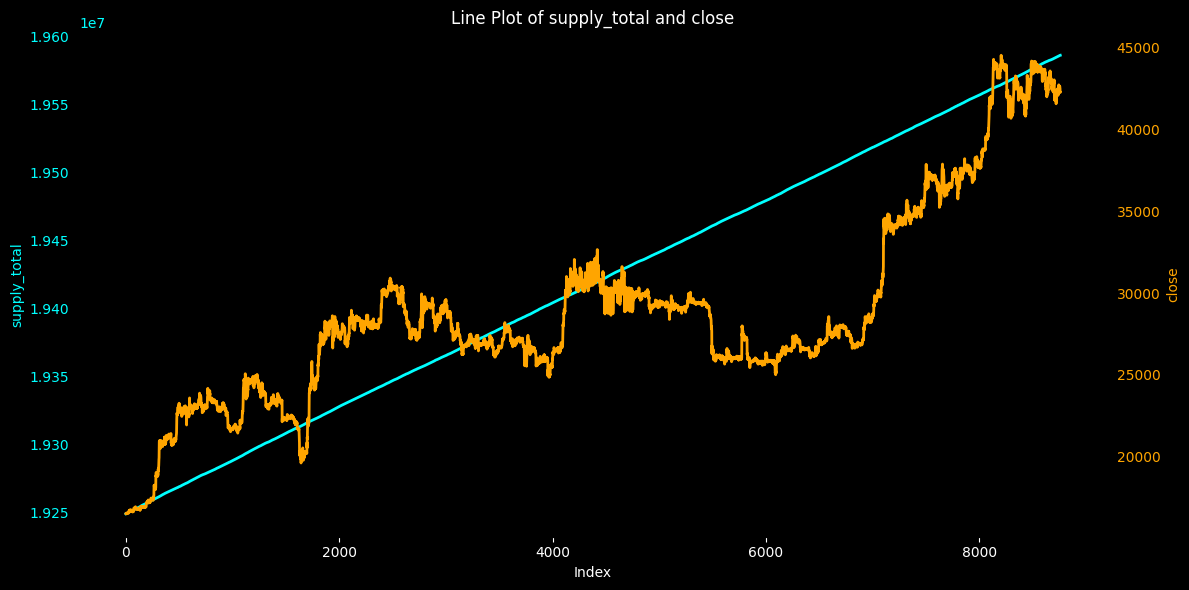

In [42]:
# supply_total & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

ax1.plot(eda_df['supply_total'], label='supply_total', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('supply_total', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Line Plot of supply_total and close', color='white')
fig.tight_layout()
plt.show()


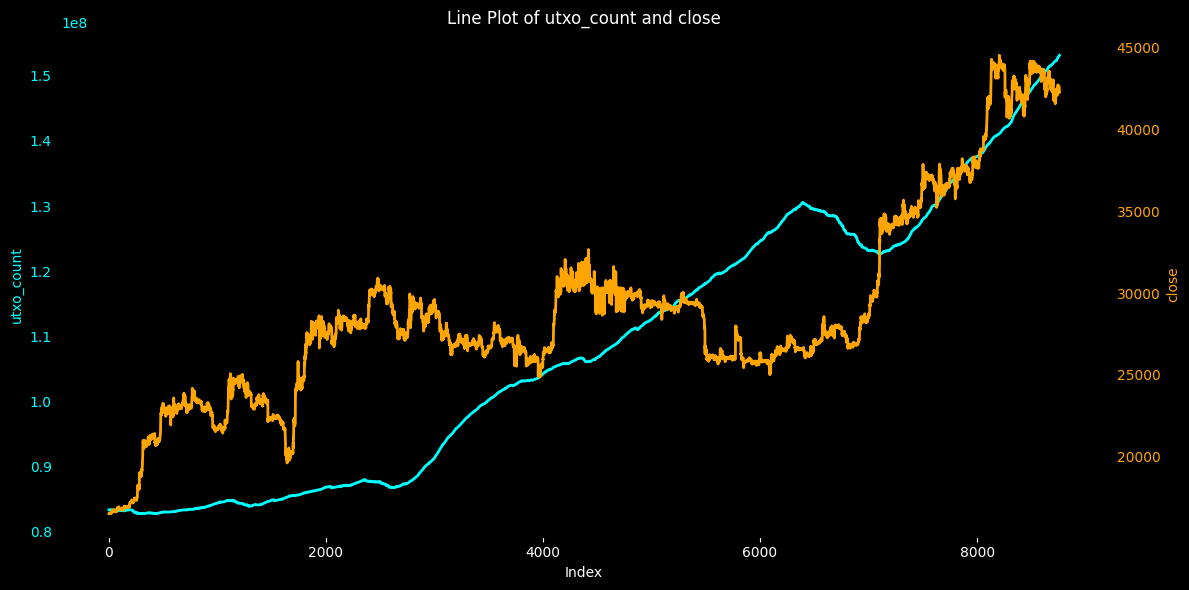

In [43]:
# utxo_count & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

ax1.plot(eda_df['utxo_count'], label='utxo_count', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('utxo_count', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Line Plot of utxo_count and close', color='white')
fig.tight_layout()
plt.show()


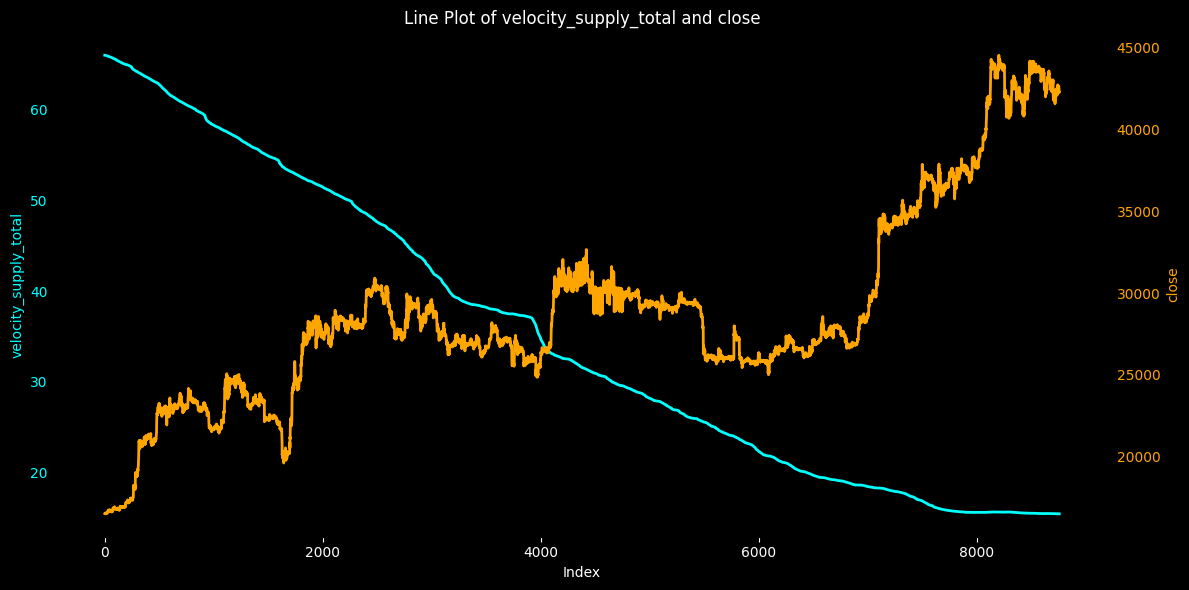

In [44]:
# velocity_supply_total & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

ax1.plot(eda_df['velocity_supply_total'], label='velocity_supply_total', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('velocity_supply_total', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Line Plot of velocity_supply_total and close', color='white')
fig.tight_layout()
plt.show()


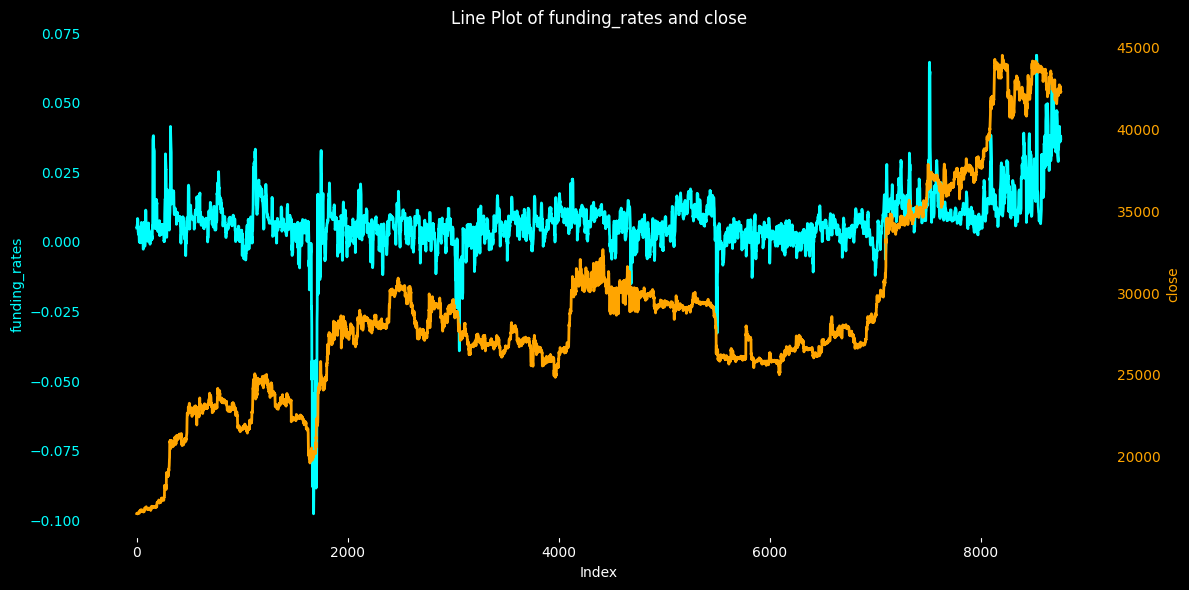

In [45]:
# funding_rates & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

ax1.plot(eda_df['funding_rates'], label='funding_rates', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('funding_rates', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Line Plot of funding_rates and close', color='white')
fig.tight_layout()
plt.show()


In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose
# ID 열이 datetime 형식인지 확인
eda_df['Date'] = pd.to_datetime(eda_df['ID'])
# Date를 인덱스로 설정
eda_df.set_index('Date', inplace=True)

# seasonal decomposition 수행
result = seasonal_decompose(eda_df['close'], model='additive', period=365)

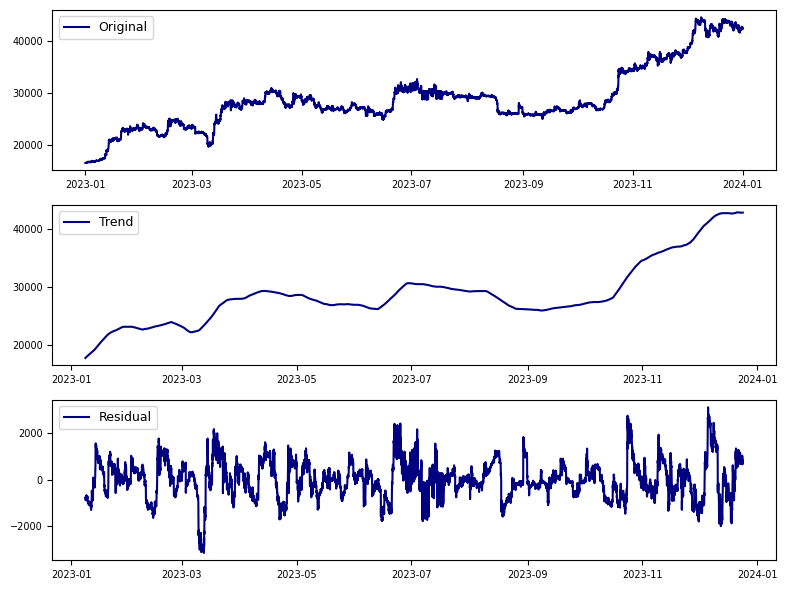

In [47]:
# 결과 시각화
plt.figure(figsize=(8, 6))

# 원본 데이터 플롯
plt.subplot(3, 1, 1)
plt.plot(eda_df["close"], label='Original', color='navy')
plt.legend(loc='upper left',fontsize=9)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

# 추세 플롯
plt.subplot(3, 1, 2)
plt.plot(result.trend, label='Trend', color='navy')
plt.legend(loc='upper left',fontsize=9)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

# 잔차 플롯
plt.subplot(3, 1, 3)
plt.plot(eda_df["close"] - result.trend, label='Residual', color='navy')
plt.legend(loc='upper left',fontsize=9)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.tight_layout()
plt.show()

### 파생 변수 생성

시각화에서 모든 변수가 서로 높은 양의 상관관계가 있다는 사실은 알아냈지만, 어떤 변수 간 조합을 해야 할 지에 대해 명확하지 않아 도메인 지식을 더해 변수를 생성하고 유의미한 지 파악한다.

#### 가정
1. open_interest / supply_total * 100
    
    시장의 관심도를 더 직관적으로 이해할 수 있다.
    
    이 값이 높다면, 시장의 관심이 총 공급량 대비 매우 높음을 나타낼 수 있다. (수요가 공급보다 높다)
2. utxo_count / supply_total
    
    네트워크의 유동성을 나타낼 수 있다.
    
    이 비율이 높다면, 많은 비트코인이 거래되지 않고 보유되고 있는 상황을 나타낼 수 있다.
3. (open_interest * difficulty) / supply_total
    
    시장의 관심도와 채굴의 어려움을 총 공급량 대비하여 나타낼 수 있다.
    
    이는 시장의 과열 여부를 판단하는 데 도움이 될 수 있다.

In [48]:
# 변수 생성
eda_df['open_interest_ratio'] = eda_df['open_interest'] / eda_df['supply_total'] * 100
eda_df['utxo_count_ratio'] = eda_df['utxo_count'] / eda_df['supply_total']
eda_df['open_interest_index'] = (eda_df['open_interest'] * eda_df['difficulty']) / eda_df['supply_total']

close_interactions = [
    'close', 'open_interest', 'open_interest_ratio', 'utxo_count_ratio', 'open_interest_index'
]

In [49]:
# close와 상관관계가 높은 feature 순으로 출력
eda_df[close_interactions].corr()['close'].sort_values(ascending =False)

close                  1.000000
open_interest_index    0.956706
open_interest          0.889183
open_interest_ratio    0.881836
utxo_count_ratio       0.761479
Name: close, dtype: float64

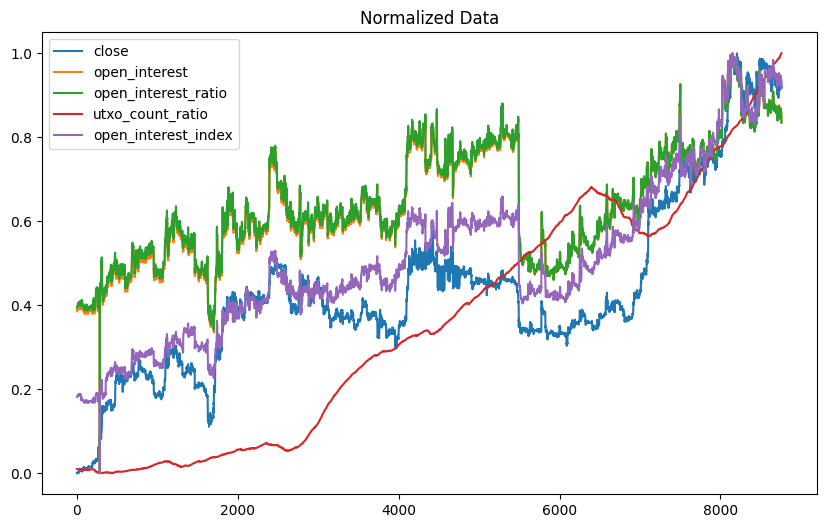

In [50]:
# 시각화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(eda_df[close_interactions])
scaled_close_interactions_df = pd.DataFrame(scaled_data, columns=close_interactions)

plt.figure(figsize=(10, 6))
for feature in close_interactions:
    plt.plot(scaled_close_interactions_df[feature], label=feature)

plt.legend()
plt.title('Normalized Data')
plt.show()

# Feature Engineering

In [51]:
# Ensemble_test
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close": "close",
    "hourly_network-data_difficulty_difficulty": "difficulty",
    "hourly_network-data_supply_supply_total": "supply_total",
    "hourly_network-data_utxo-count_utxo_count": "utxo_count",
    "hourly_network-data_velocity_velocity_supply_total": "velocity_supply_total"
}
df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape

(11552, 10)

In [52]:
# 시차변수 생성을 위한 열을 따로 할당해둠
conti_cols: List[str] = [
    "close",
    "open_interest",
    "difficulty",
    "supply_total",
    "utxo_count",
    "funding_rates",
    "velocity_supply_total"
]

# 최대 5시간의 시차변수를 계산
shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 6)]
)

# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

In [53]:
df.head()

,ID,target,_type,funding_rates,open_interest,close,difficulty,supply_total,utxo_count,velocity_supply_total,...,funding_rates_1,funding_rates_2,funding_rates_3,funding_rates_4,funding_rates_5,velocity_supply_total_1,velocity_supply_total_2,velocity_supply_total_3,velocity_supply_total_4,velocity_supply_total_5
0,2023-01-01 00:00:00,2.0,train,0.005049,6.271344e+09,16536.747967,3.536407e+13,1.924871e+07,83308092.0,65.978971,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-01 01:00:00,1.0,train,0.005049,6.288683e+09,16557.136536,3.536407e+13,1.924874e+07,83314883.0,65.977755,...,0.005049,NaN,NaN,NaN,NaN,65.978971,NaN,NaN,NaN,NaN
2,2023-01-01 02:00:00,1.0,train,0.005049,6.286796e+09,16548.149805,3.536407e+13,1.924879e+07,83314090.0,65.975570,...,0.005049,0.005049,NaN,NaN,NaN,65.977755,65.978971,NaN,NaN,NaN
3,2023-01-01 03:00:00,1.0,train,0.005067,6.284575e+09,16533.632875,3.536407e+13,1.924882e+07,83326258.0,65.975092,...,0.005049,0.005049,0.005049,NaN,NaN,65.975570,65.977755,65.978971,NaN,NaN
4,2023-01-01 04:00:00,2.0,train,0.006210,6.291582e+09,16524.712159,3.536407e+13,1.924886e+07,83339168.0,65.969825,...,0.005067,0.005049,0.005049,0.005049,NaN,65.975092,65.975570,65.977755,65.978971,NaN


In [54]:
# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

# Model Train

In [55]:
X_train = train_df.drop(["ID", "target", "close"], axis=1)
y_train = train_df["close"]
target = train_df["target"]

In [56]:
def close_to_class(series: pd.Series) -> pd.Series:
    """close 변수를 target값으로 변환하는 함수입니다.

    Args:
        series (pd.Series): 변환을 원하는 close 변수

    Returns:
        pd.Series: 변환된 target 값
    """
    close = pd.DataFrame()
    close['close'] = series
    close['close_lag1'] = close['close'].shift(1)
    close['close_lag1_percent'] = (close['close'] - close['close_lag1']) / close['close_lag1']
    close['class'] = close['close']
    for i in range(close.shape[0]):
        if close.loc[i, 'close_lag1_percent'] < -0.005:
            close.loc[i, 'class'] = 0
        elif close.loc[i, 'close_lag1_percent'] < 0:
            close.loc[i, 'class'] = 1
        elif close.loc[i, 'close_lag1_percent'] < 0.005:
            close.loc[i, 'class'] = 2
        else:
            close.loc[i, 'class'] = 3
            
    return close["class"].shift(-1).fillna(method="ffill")

In [57]:
# 모델 평가
def evaluate(valid_target: pd.Series, 
             y_valid: pd.Series, 
             y_pred: np.ndarray, 
             metric: str
) -> float:
    """평가지표 metric을 반환하는 함수입니다.

    Args:
        valid_target: (pd.Series): k-fold로 분할한 target의 검증 데이터
        y_valid (pd.Series): k-fold로 분할한 close의 검증 데이터
        y_pred (np.ndarray): 모델을 사용하여 예측한 변수
        metric (str): 사용할 평가지표 metric 이름

    Returns:
        float: 사용할 평가지표 metric 값
    """
    if metric == "accuracy":
        y_pred_class = close_to_class(y_pred)
        return accuracy_score(valid_target, y_pred_class)
    elif metric == "mae":
        return mean_absolute_error(y_valid, y_pred)
    elif metric == "mse":
        return mean_squared_error(y_valid, y_pred)
    elif metric == "mape":
        return mean_absolute_percentage_error(y_valid, y_pred)

In [58]:
def model_train(model: Any, 
                X_train: pd.DataFrame, 
                y_train: pd.Series, 
                cv: int, 
                metric: str, 
) -> Tuple[Any, float]:
    """K-Fold로 데이터를 분할한 후 전처리를 거쳐 주어진 모델로 데이터를 학습 및 평가를 진행합니다.

    Args:
        model (Any): 사용하는 모델 객체
        X_train (pd.DataFrame): 설명변수로 이루어진 학습 데이터프레임
        y_train (pd.Seris): 예측변수로 이루어진 학습 시리즈
        cv (int): 교차 검증시 분할할 폴드의 수
        metric (str): 사용할 평가지표 metric 이름

    Returns:
        (Any, float): 폴드 내에서 가장 평가지표 값이 높은 모델 객체, 평가지표 metric 값
    """
    kfold = KFold(n_splits=cv)
    score_list = []
    fold_model = []
    
    # warm_start는 모델의 속성으로, 같은 모델을 반복 학습할 때 이전 학습에서 학습된 파라미터를 초기화하지 않고 이어서 학습을 진행하는 옵션
    if hasattr(model, "warm_start"):
        model.warm_start = True

    # K-Fold 교차 검증
    for train_index, valid_index in kfold.split(X_train):
        X_train_fold, y_train_fold = X_train.iloc[train_index], y_train.iloc[train_index]
        X_valid, y_valid = X_train.iloc[valid_index], y_train.iloc[valid_index]

        valid_target = target[valid_index]
        
        # 전처리
        fill_feature(X_train_fold, method="mean")
        fill_feature(X_valid, method="mean")        
        
        # 모델 학습
        model.fit(X_train_fold, y_train_fold)
        fold_model.append(model)

        y_pred = model.predict(X_valid)
        score = evaluate(valid_target, y_valid, y_pred, metric=metric)  # 평가지표 metric 반환
        score_list.append(score)

    if metric == "accuracy":
        return fold_model[np.argmax(score_list)], np.max(score_list)
    
    return fold_model[np.argmin(score_list)], np.min(score_list)

## Model Ensemble

각각의 모델에 대해 유용한 피처를 할당해주는 방식으로 앙상블을 진행

In [59]:
# Lasso에만 사용할 피처
cols_dict_for_lasso = [
    "open_interest",
    "difficulty",
    "supply_total",
    "utxo_count",
    "funding_rates",
    "velocity_supply_total"
]

In [60]:
# shift_feature로 생성된 컬럼들을 cols_dict_for_lasso에 추가
for col in conti_cols:
    for interval in range(1, 6):
        cols_dict_for_lasso.append(f"{col}_{interval}")

In [61]:
cols_dict_for_lgb = [
    "open_interest",
    "difficulty",
    "supply_total",
    "utxo_count",
    "funding_rates",
    "velocity_supply_total"
]

In [62]:
# shift_feature로 생성된 컬럼들을 cols_dict_for_lgb에 추가
for col in conti_cols:
    for interval in range(1, 6):
        cols_dict_for_lgb.append(f"{col}_{interval}")

In [63]:
cols_dict_for_xgb = [
    "open_interest",
    "difficulty",
    "supply_total",
    "utxo_count",
    "funding_rates",
    "velocity_supply_total"
]

In [64]:
# shift_feature로 생성된 컬럼들을 cols_dict_for_xgb에 추가
for col in conti_cols:
    for interval in range(1, 6):
        cols_dict_for_xgb.append(f"{col}_{interval}")

In [65]:
# 다음 두 하이퍼파라미터 조합은 각각의 모델링에서 optuna를 통해 최적의 하이퍼파라미터를 구한 결과입니다.

xgb_params = {
    'n_estimators': 159,
    'learning_rate': 0.044545369253400344,
    'max_depth': 7,
    'min_child_weight': 5,
    'colsample_bytree': 0.5878501242431816,
    'subsample': 0.7729401646786744,
    "booster": "gbtree",
    "device": "gpu",
    "random_state": 42
}

lgb_params = {
    "verbose" : -1,
    'num_leaves': 77,
    'learning_rate': 0.019576305246645095,
    'n_estimators': 294,
    'max_depth': 8,
    'min_child_weight': 1,
    'subsample': 0.6520270159934872,
    'colsample_bytree': 0.5000782016959966,
    "random_state" : 42
}

In [66]:
# 파이프라인 구성
lasso_pipeline = Pipeline([
    ('feature_select', ColumnTransformer([("select", "passthrough", cols_dict_for_lasso)], remainder="drop")),
    #('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=20, max_iter=2000, random_state=42))
])

xgb_pipeline = Pipeline([
    ('feature_select', ColumnTransformer([("select", "passthrough", cols_dict_for_xgb)], remainder="drop")),
    ('xgb', XGBRegressor(**xgb_params))
])

lgb_pipeline = Pipeline([
    ('feature_select', ColumnTransformer([("select", "passthrough", cols_dict_for_lgb)], remainder="drop")),
    ('lgb', lgb.LGBMRegressor(**lgb_params))
])

In [67]:
# 목적함수 정의
def objective(trial):
    weight_xgb = trial.suggest_float("weight_xgb", 0.1, 3.0)
    weight_lgb = trial.suggest_float("weight_lgb", 0.1, 3.0)
    weight_lr = trial.suggest_float("weight_lr", 0.1, 3.0)
    
    ensemble_model = VotingRegressor(
        estimators=[
            ('xgb', xgb_pipeline),
            ('lgb', lgb_pipeline),
            ('lr', lasso_pipeline)
        ],
        weights=[weight_xgb, weight_lgb, weight_lr]
    )
    
    _, score = model_train(ensemble_model, X_train, y_train, cv=5, metric="accuracy")
    return score

In [68]:
# Optuna로 가중치 최적화
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2024-09-27 03:13:03,328] A new study created in memory with name: no-name-bdbb9006-b4ea-4492-ab31-897be79b0876
[I 2024-09-27 03:13:40,176] Trial 0 finished with value: 0.4743150684931507 and parameters: {'weight_xgb': 2.9001624400140193, 'weight_lgb': 0.23786604312937853, 'weight_lr': 2.134005502101714}. Best is trial 0 with value: 0.4743150684931507.
[I 2024-09-27 03:14:07,864] Trial 1 finished with value: 0.4754566210045662 and parameters: {'weight_xgb': 1.3377029535813931, 'weight_lgb': 1.6521792960755022, 'weight_lr': 2.7408914104018747}. Best is trial 1 with value: 0.4754566210045662.
[I 2024-09-27 03:14:37,609] Trial 2 finished with value: 0.4868721461187215 and parameters: {'weight_xgb': 0.9015801109632968, 'weight_lgb': 0.4241453101039342, 'weight_lr': 2.7879606194770408}. Best is trial 2 with value: 0.4868721461187215.
[I 2024-09-27 03:15:08,398] Trial 3 finished with value: 0.4754566210045662 and parameters: {'weight_xgb': 0.47291411860734534, 'weight_lgb': 2.0660563589634

In [69]:
# 최적 가중치를 사용한 최종 모델 구성
best_weights = [
    study.best_params["weight_xgb"],
    study.best_params["weight_lgb"],
    study.best_params["weight_lr"]
]

ensemble_model = VotingRegressor(
    estimators=[('xgb', xgb_pipeline), ('lgb', lgb_pipeline), ('lr', lasso_pipeline)],
    weights=best_weights
)


In [70]:
# 학습
Best_ensemble_model, model_accuracy = model_train(ensemble_model, X_train, y_train, cv=5, metric="accuracy")
print(f"Ensemble model accuracy: {model_accuracy}")

Ensemble model accuracy: 0.4914383561643836


## Inference

In [71]:
# Best_ensemble_model이 학습 데이터 전체를 학습할 수 있도록 결측치 처리

X_train = fill_feature(X_train, method="mean") # train data 결측치 처리
X_test = test_df.drop(["ID", "target", "close"], axis=1)
X_test = fill_feature(X_test, method="mean") # test data 결측치 처리

In [72]:
# 최적의 모델로 예측
Best_ensemble_model.fit(X_train, y_train)
y_test_pred = Best_ensemble_model.predict(X_test)
y_test_pred_class = close_to_class(y_test_pred)

In [73]:
# output file
submission_df = submission_df.assign(target = y_test_pred_class)
submission_df["target"] = submission_df["target"].astype(np.int8)
submission_df.to_csv("output.csv", index=False)

In [74]:
# 클래스 분포 확인
submission_df['target'].value_counts()

target
2    1385
1    1294
3      62
0      51
Name: count, dtype: int64